In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

In [3]:
import os
os.getcwd()

'C:\\Users\\asma0'

In [4]:
os.chdir(r"C:\Users\asma0\OneDrive\Desktop\audio")

In [5]:
import os
os.getcwd()

'C:\\Users\\asma0\\OneDrive\\Desktop\\audio'

In [15]:
# READ IN AUDIO FILES 
audio = "/Users/asma0/OneDrive/Desktop/audio/Actors/"

In [16]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('/Users/asma0/OneDrive/Desktop/audio/audio.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
1,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
2,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
3,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
4,male,calm,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...


In [17]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [18]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


# Add Noise, Stretch, Speed and Pitch to Original Audio File


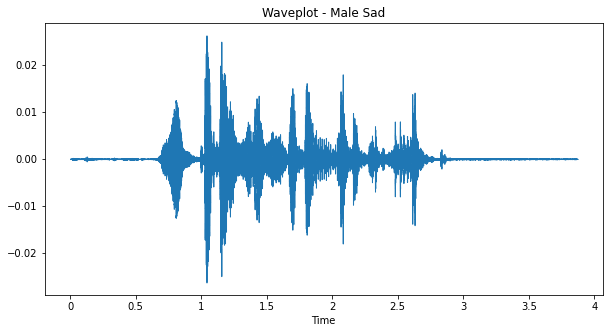

In [19]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')

In [20]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

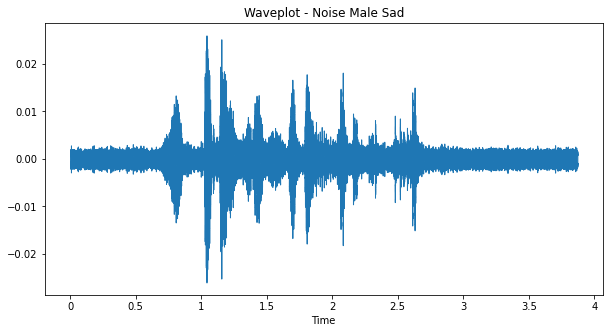

In [21]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')

In [22]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

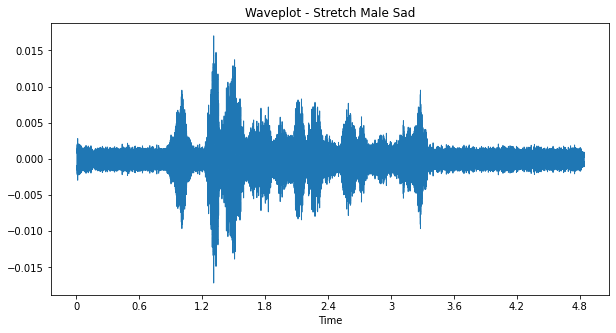

In [23]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [24]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

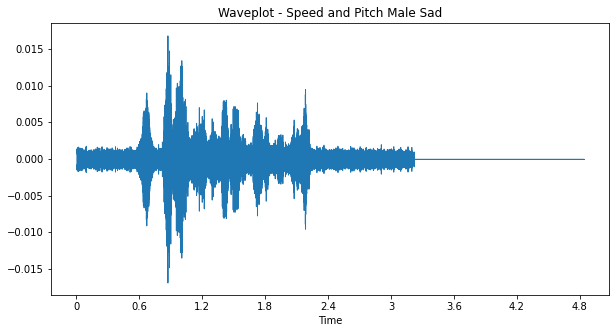

In [25]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

# Apply Data Augmentation Methods to Train Set


In [26]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-52.010746, -52.010746, -52.010746, -52.01074..."
1,"[-67.54296, -67.40218, -67.50767, -67.28868, -..."
2,"[-68.69961, -68.47577, -68.51181, -68.62947, -..."
3,"[-47.35137, -44.50162, -44.96732, -46.385986, ..."
4,"[-60.713932, -60.732025, -60.605186, -60.55268..."


In [27]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-52.010746, -52.010746, -52.010746, -52.01074..."
1,"[-67.54296, -67.40218, -67.50767, -67.28868, -..."
2,"[-68.69961, -68.47577, -68.51181, -68.62947, -..."
3,"[-47.35137, -44.50162, -44.96732, -46.385986, ..."
4,"[-60.713932, -60.732025, -60.605186, -60.55268..."


In [28]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-54.761242, -54.761242, -54.761242, -54.76124..."
1,"[-68.733505, -68.6323, -68.42782, -68.39562, -..."
2,"[-69.968056, -69.783676, -69.93132, -70.14405,..."
3,"[-49.109818, -46.6253, -48.110012, -47.83593, ..."
4,"[-60.63328, -60.47585, -60.41199, -60.567055, ..."


In [29]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-52.010746, -52.010746, -52.010746, -52.01074..."
1,"[-67.54296, -67.40218, -67.50767, -67.28868, -..."
2,"[-68.69961, -68.47577, -68.51181, -68.62947, -..."
3,"[-47.35137, -44.50162, -44.96732, -46.385986, ..."
4,"[-60.713932, -60.732025, -60.605186, -60.55268..."


# Combine Tables For Modeling


In [30]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [31]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [32]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [33]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [34]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [35]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-55.730511,-54.623352,-54.550468,-55.437660,-55.961685,-56.114368,-56.143417,-56.143417,-56.094406,-56.066547,...,-55.760586,-55.863258,-55.977577,-55.949165,-56.030972,-55.987911,-56.052181,-56.137798,-56.143417,angry
4604,-61.237335,-64.420082,-68.027878,-67.974037,-67.892975,-68.036377,-68.088753,-68.015907,-67.908852,-67.855492,...,-67.717865,-67.658531,-67.485863,-67.343231,-67.607063,-67.701698,-67.846138,-67.250557,-64.481056,sad
4605,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,-76.050079,-76.409142,-76.470604,-76.470604,-76.470604,...,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,-76.470604,sad
4606,-83.325623,-77.880127,-75.284637,-74.842278,-75.249420,-75.107201,-74.637909,-74.498016,-74.597610,-75.026855,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4607,-70.672348,-70.654152,-70.727898,-70.727898,-70.727898,-70.720848,-70.727898,-70.727898,-70.727898,-70.727898,...,-67.000000,-67.503555,-59.271938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fear


In [36]:
mfcc.shape


(1152, 260)

In [37]:
noise.shape


(1152, 260)

In [38]:
speedpitch.shape

(1152, 260)

In [39]:
stretch.shape

(1152, 260)

In [40]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

# Feature Extraction for Test Set


In [41]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-52.76461, -52.76461, -52.76461, -52.76461, -..."
1,"[-61.348904, -58.16661, -56.613895, -55.79111,..."
2,"[-52.7257, -52.065536, -51.75754, -51.135387, ..."
3,"[-52.10144, -52.10144, -52.10144, -52.10144, -..."
4,"[-61.69267, -60.6925, -59.880936, -59.58907, -..."


In [42]:
test.reset_index(drop=True,inplace=True)


In [43]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...,-52.764610,-52.764610,-52.764610,-52.764610,-52.764610,-52.764610,...,-44.242558,-44.894524,-44.903637,-45.033726,-45.896713,-46.566990,-47.167763,-47.958069,-48.450417,-50.117027
1,male,calm,21,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...,-61.348904,-58.166611,-56.613895,-55.791111,-55.212570,-54.984646,...,-66.573532,-66.789375,-66.874863,-67.514870,-67.820511,-68.417465,-68.950706,-70.195488,-69.929504,-70.323647
2,female,happy,16,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...,-52.725700,-52.065536,-51.757542,-51.135387,-50.810482,-50.662903,...,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433
3,female,angry,12,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...,-52.101440,-52.101440,-52.101440,-52.101440,-52.101440,-52.101440,...,-51.317684,-51.431118,-51.392258,-51.352699,-51.350124,-51.355049,-51.364803,-51.371239,-49.596691,-43.098038
4,male,fear,23,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...,-61.692669,-60.692501,-59.880936,-59.589069,-59.193195,-59.109444,...,-61.862492,-60.641975,-60.076622,-60.019165,-60.279964,-59.827858,-59.647198,-59.799290,-59.236088,-58.240932


In [44]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [45]:
# CHECK TOP 5 ROWS
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-52.764610,-52.764610,-52.764610,-52.764610,-52.764610,-52.764610,-52.764610,...,-44.242558,-44.894524,-44.903637,-45.033726,-45.896713,-46.566990,-47.167763,-47.958069,-48.450417,-50.117027
1,male,calm,21,-61.348904,-58.166611,-56.613895,-55.791111,-55.212570,-54.984646,-53.901905,...,-66.573532,-66.789375,-66.874863,-67.514870,-67.820511,-68.417465,-68.950706,-70.195488,-69.929504,-70.323647
2,female,happy,16,-52.725700,-52.065536,-51.757542,-51.135387,-50.810482,-50.662903,-50.606270,...,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433,-53.233433
3,female,angry,12,-52.101440,-52.101440,-52.101440,-52.101440,-52.101440,-52.101440,-52.101440,...,-51.317684,-51.431118,-51.392258,-51.352699,-51.350124,-51.355049,-51.364803,-51.371239,-49.596691,-43.098038
4,male,fear,23,-61.692669,-60.692501,-59.880936,-59.589069,-59.193195,-59.109444,-58.650024,...,-61.862492,-60.641975,-60.076622,-60.019165,-60.279964,-59.827858,-59.647198,-59.799290,-59.236088,-58.240932


In [47]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

# Data Preprocessing


In [48]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [49]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [50]:
y_train


array([['angry'],
       ['surprise'],
       ['surprise'],
       ...,
       ['sad'],
       ['calm'],
       ['fear']], dtype=object)

In [51]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [52]:
print(lb.classes_)


['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [53]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [54]:
X_train.shape[0]

4608

# CNN


In [55]:
# BUILD 1D CNN LAYERS
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=1e-6)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 64)           1344      
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            327808    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                    

In [56]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=20, validation_data=(X_test, y_test),callbacks=checkpoint)

Epoch 1/20
575/576 [============================>.] - ETA: 0s - loss: 1.8103 - accuracy: 0.3128
Epoch 1: val_loss improved from inf to 1.63443, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 22s 36ms/step - loss: 1.8098 - accuracy: 0.3127 - val_loss: 1.6344 - val_accuracy: 0.4306
Epoch 2/20
575/576 [============================>.] - ETA: 0s - loss: 1.5978 - accuracy: 0.3863
Epoch 2: val_loss improved from 1.63443 to 1.55289, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 20s 34ms/step - loss: 1.5985 - accuracy: 0.3863 - val_loss: 1.5529 - val_accuracy: 0.3750
Epoch 3/20
575/576 [============================>.] - ETA: 0s - loss: 1.4884 - accuracy: 0.4428
Epoch 3: val_loss improved from 1.55289 to 1.49807, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 20s 34ms/step - loss: 1.4885 - accuracy: 0.4427 - val_loss: 1.4981 - val_accuracy: 0.4583
Epoch 4/20
575/576 [============================>.] - ETA: 0s - loss: 1.3973 - accuracy: 0.4865
Epoch 4: val_loss improved from 1.49807 to 1.39744, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 20s 35ms/step - loss: 1.3973 - accuracy: 0.4868 - val_loss: 1.3974 - val_accuracy: 0.4826
Epoch 5/20
576/576 [==============================] - ETA: 0s - loss: 1.3231 - accuracy: 0.5150
Epoch 5: val_loss did not improve from 1.39744
576/576 [==============================] - 19s 33ms/step - loss: 1.3231 - accuracy: 0.5150 - val_loss: 1.4390 - val_accuracy: 0.4861
Epoch 6/20
575/576 [============================>.] - ETA: 0s - loss: 1.2618 - accuracy: 0.5391
Epoch 6: val_loss improved from 1.39744 to 1.38662, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.2622 - accuracy: 0.5386 - val_loss: 1.3866 - val_accuracy: 0.5035
Epoch 7/20
575/576 [============================>.] - ETA: 0s - loss: 1.1710 - accuracy: 0.5804
Epoch 7: val_loss did not improve from 1.38662
576/576 [==============================] - 19s 33ms/step - loss: 1.1708 - accuracy: 0.5803 - val_loss: 1.3892 - val_accuracy: 0.5104
Epoch 8/20
575/576 [============================>.] - ETA: 0s - loss: 1.1016 - accuracy: 0.6089
Epoch 8: val_loss did not improve from 1.38662
576/576 [==============================] - 17s 30ms/step - loss: 1.1019 - accuracy: 0.6087 - val_loss: 1.4315 - val_accuracy: 0.5382
Epoch 9/20
575/576 [============================>.] - ETA: 0s - loss: 1.0365 - accuracy: 0.6402
Epoch 9: val_loss did not improve from 1.38662
576/576 [==============================] - 16s 28ms/step - loss: 1.0369 - accuracy: 0.6402 - val_loss: 1.5971 - val_accuracy: 0.5174
Epoch 10/20
575/576 [==================

In [57]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
model.save_weights("best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

Saved model to disk


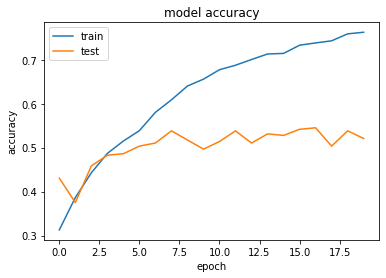

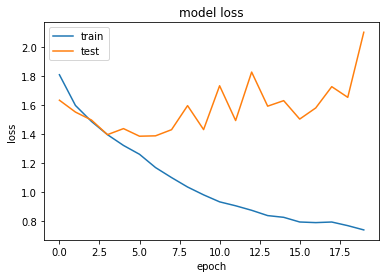

In [59]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [60]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

9/9 [==============================] - 0s 11ms/step


,Actual Values,Predicted Values
140,sad,neutral
141,surprise,surprise
142,neutral,calm
143,sad,sad
144,fear,surprise
145,sad,fear
146,disgust,disgust
147,angry,angry
148,surprise,happy
149,angry,angry


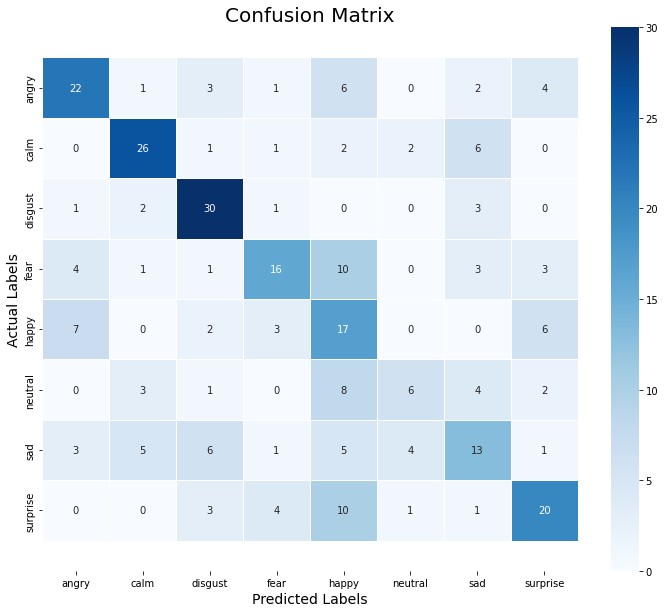

In [61]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.59      0.56      0.58        39
        calm       0.68      0.68      0.68        38
     disgust       0.64      0.81      0.71        37
        fear       0.59      0.42      0.49        38
       happy       0.29      0.49      0.37        35
     neutral       0.46      0.25      0.32        24
         sad       0.41      0.34      0.37        38
    surprise       0.56      0.51      0.53        39

    accuracy                           0.52       288
   macro avg       0.53      0.51      0.51       288
weighted avg       0.53      0.52      0.52       288



# Hyperparameter Tuning


In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

In [64]:
# STRATIFIED SHUFFLE SPLIT
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [65]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [66]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
# RESHAPE DATA TO 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [68]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [69]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
model = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [50, 75, 100],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 250, 64)           704       
                                                                 
 conv1d_4 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 128)           0         
 1D)                                                  